In [36]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
# torch.manual_seed(seed=42) 
os.makedirs('./model_para', exist_ok=True)

In [37]:
class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=128):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),       
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),   
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)

In [38]:
def potential(x,k,scale=100):
    # poten=-1/x*scale
    # return poten-k*(l+1)*l/x**2
    
    poten=2*x**2+3*torch.sin(torch.pi*x/2.4)*x*(1-torch.exp(-x/6))
    return poten

In [39]:
def energy(en_level,l,k,scale,device,dtype):
    en_list=[scale**2/(4*k*(i+1)**2) for i in range(en_level)]
    en_list=torch.tensor(en_list,device=device,dtype=dtype)
    return en_list

In [40]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

La=0
Lb =20
L=Lb-La  # domain length
N = 4000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)

# 控制势函数的大小
l_max=1
scale=10

en_num=40
extend_num=10
epoch=200000
lr=0.01

diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

In [41]:
real_en_list=[]
for l in range(l_max):
    centrifugal_poten=-b_lap*(l+1)*l/grid**2
    V_diag=potential(grid,b_lap,scale)+centrifugal_poten
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    real_en=eigenvalues[:en_num].detach()
    real_en_list.append(real_en)

In [42]:
model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=50,threshold=1e-4)
loss_fn=nn.L1Loss()

loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    
    loss=0
    for l in range(l_max):
        centrifugal_poten=-b_lap*(l+1)*l/grid**2
        V_diag=model(grid)+centrifugal_poten
        A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
        eigenvalues= torch.linalg.eigvalsh(A)
        output=eigenvalues[:en_num]
        
        loss+=loss_fn(output,real_en_list[l])
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if i%10==0:
        print(f'epoch:{i},loss:{loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
    
    if (i+1)%100==0:torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')
    scheduler.step(loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
    
final_loss=loss.item()
final_time=time.time()-init_time
final_epoch=i+1
print('terminal epoch: ',i+1)
torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')


epoch:0,loss:73.68115234375,time:0.10675764083862305,lr:0.01
epoch:10,loss:23.991214752197266,time:1.1365687847137451,lr:0.01
epoch:20,loss:8.127830505371094,time:2.167386293411255,lr:0.01
epoch:30,loss:3.373445987701416,time:3.197965621948242,lr:0.01
epoch:40,loss:1.1875146627426147,time:4.229255437850952,lr:0.01
epoch:50,loss:3.740441083908081,time:5.259197950363159,lr:0.01
epoch:60,loss:1.1889722347259521,time:6.284275054931641,lr:0.01
epoch:70,loss:3.229989767074585,time:7.310719966888428,lr:0.01
epoch:80,loss:2.960160255432129,time:8.340028285980225,lr:0.01
epoch:90,loss:2.425636053085327,time:9.364712476730347,lr:0.01
epoch:100,loss:2.093824625015259,time:10.390796422958374,lr:0.01
epoch:110,loss:1.7253608703613281,time:11.414344310760498,lr:0.01
epoch:120,loss:2.841560125350952,time:12.438598871231079,lr:0.01
epoch:130,loss:0.8723196387290955,time:13.463825464248657,lr:0.001
epoch:140,loss:0.8542190790176392,time:14.492581605911255,lr:0.001
epoch:150,loss:0.8025321364402771,time

In [43]:
# -1.5237e-01, -1.3085e-01, -1.2296e-01, -1.0179e-01, -7.9435e-02,
#         -5.6185e-02, -3.5326e-02, -1.0974e-02,  1.4396e-02,  4.2974e-02
# -1.2695e-01, -9.2922e-02, -5.8262e-02, -2.2549e-02,  1.4835e-02,
#          5.1943e-02,  9.0080e-02,  1.2834e-01,  1.6763e-01,  2.0718e-01

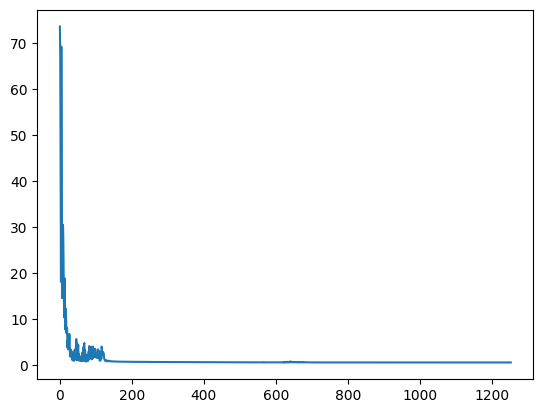

In [44]:
plt.plot(loss_list)
plt.show()

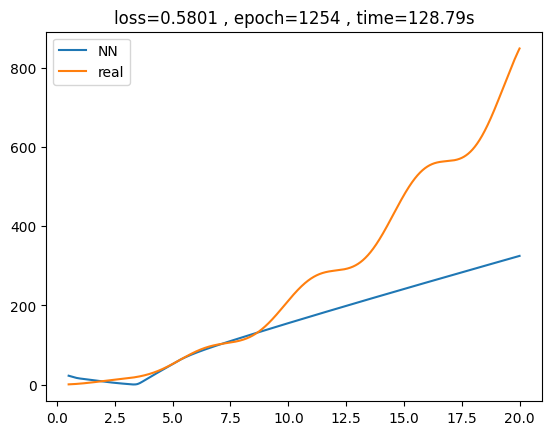

In [45]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[100:]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()


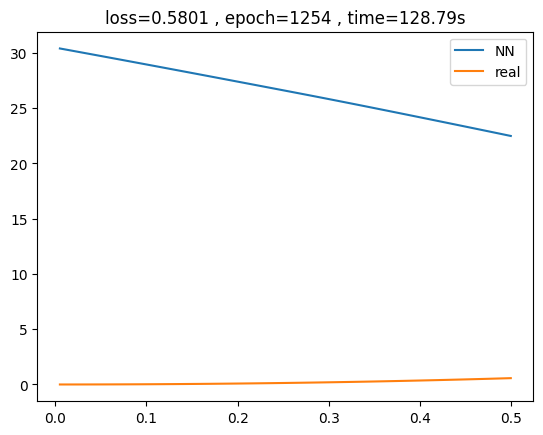

In [46]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[:100]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()

In [47]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
V_diag=model(grid)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
output=eigenvalues[:en_num]

real_en=real_en_list[0]
error=output-real_en
rela_error=error/real_en
print('final error:',error)
print('relative error:',rela_error)

final error: tensor([-1.9670e-04,  2.1443e-03, -3.0909e-03,  2.1172e-03, -1.5362e-02,
         1.8751e-02,  3.7306e-02,  2.6703e-04, -5.1212e-02, -7.9411e-02,
        -6.0162e-02, -6.8283e-04,  5.9505e-02,  1.1775e-01,  1.5850e-01,
         1.7253e-01,  1.2209e-01, -1.2970e-04, -2.3367e-01, -4.8682e-01,
        -7.7836e-01, -1.0481e+00, -1.2423e+00, -1.2898e+00, -1.0932e+00,
        -6.1105e-01,  2.1400e-02,  5.9159e-01,  1.0132e+00,  1.2831e+00,
         1.3940e+00,  1.3533e+00,  1.2008e+00,  9.0866e-01,  5.3093e-01,
         1.0376e-03, -6.1879e-01, -1.3481e+00, -2.1692e+00, -3.0851e+00],
       device='cuda:1', grad_fn=<SubBackward0>)
relative error: tensor([-5.9821e-05,  2.8224e-04, -2.6915e-04,  1.4159e-04, -8.4118e-04,
         8.6578e-04,  1.4791e-03,  9.2190e-06, -1.5579e-03, -2.1502e-03,
        -1.4630e-03, -1.5031e-05,  1.1941e-03,  2.1679e-03,  2.6928e-03,
         2.7191e-03,  1.7938e-03, -1.7845e-06, -3.0239e-03, -5.9500e-03,
        -9.0213e-03, -1.1565e-02, -1.3106e-02,

energy level while l=0


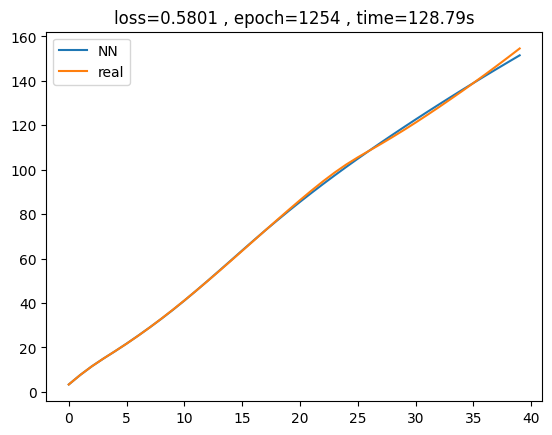

In [48]:
print('energy level while l=0')
plt.plot(output[:].detach().cpu().numpy(),label='NN')
plt.plot(real_en[:].detach().cpu().numpy(),label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()

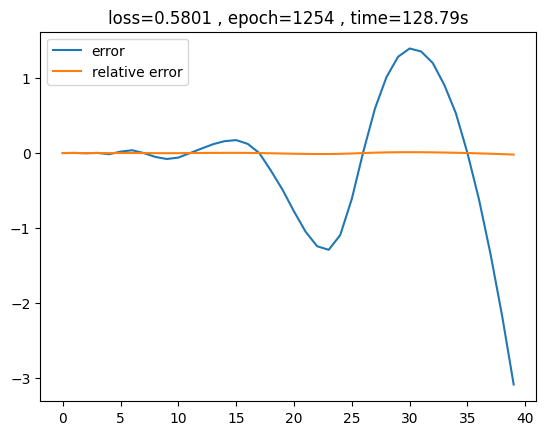

In [49]:
plt.plot(error.detach().cpu().numpy(),label='error')
plt.plot(rela_error.detach().cpu().numpy(),label='relative error')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()